<a href="https://colab.research.google.com/github/abhi-gm/Microsoft-Vision-Transfer-Learning/blob/main/Microsoft_Vision_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction**

Aim of the notebook is to provide an example for using state of the art Microsoft Vision Model for transfer learning to classify the Fruits with 81 classes.

**Data** - can be dowloaded [here](https://data.mendeley.com/datasets/rp73yg93n8/1/files/56487963-3773-495e-a4fc-c1862b6daf91)

In [2]:
# importing reguired files
import os
from shutil import copyfile
from os import getcwd
import shutil
import copy
import time
import torch
import helper
import zipfile
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch import Tensor
from torchvision import datasets
import torch.nn.functional as F
import torch.optim as optim
from progressbar import progressbar
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# **2. Download the Data**

In [3]:

!wget --no-check-certificate \
    https://data.mendeley.com/public-files/datasets/rp73yg93n8/files/56487963-3773-495e-a4fc-c1862b6daf91/file_downloaded \
    -O /content/fruits-360_dataset.zip

--2021-08-01 19:55:02--  https://data.mendeley.com/public-files/datasets/rp73yg93n8/files/56487963-3773-495e-a4fc-c1862b6daf91/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/8648f1ec-9c4c-4bad-8f85-230041d37a39 [following]
--2021-08-01 19:55:03--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/8648f1ec-9c4c-4bad-8f85-230041d37a39
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.112.32
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.112.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 425342676 (406M) [applicati

## **2.1 Unzip the data**

In [4]:
local_zip = '/content/fruits-360_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

# **3. Prepare the Dataset**

In [5]:
!pip install split-folders tqdm

## **3.1 Split the Training Dataset into train and validation sets**

In [6]:
import splitfolders  

destination = '/content/fruits-360/'
source = '/content/fruits-360/' +'Training/'
splitfolders.ratio(source, output=destination, seed=1337, ratio=(0.8, 0.2, 0), group_prefix=None)
shutil.rmtree('/content/fruits-360/test')

Copying files: 41322 files [00:05, 6898.54 files/s]


## **3.2 Define dir path**

In [7]:
# define the path required to access the data

base_dir = '/content/fruits-360/'
train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'val/')
test_dir = os.path.join(base_dir,'Test/')

# **4. Feature Extraction using Microsoft vision**

## **4.1 Install Microsoft Vision** 

In [8]:
# install the microsoft vision module
!pip install microsoftvision

#import the microsft vision module
import microsoftvision

     |████████████████████████████████| 345 kB 7.0 MB/s 
     |████████████████████████████████| 108 kB 15.0 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 3.2 MB 13.2 MB/s 
     |████████████████████████████████| 163 kB 47.5 MB/s 
     |████████████████████████████████| 85 kB 4.9 MB/s 
     |████████████████████████████████| 45 kB 4.0 MB/s 


## **4.2 Preprocess the image required for Microsoft Vision**

In [9]:
class Preprocess:
  '''
  preprocess is the class for preprocessing the 
  data that is feed into the vision module
  these are requirements of the vision
  module
  '''
  def __init__(self):
    self.Preprocess = transforms.Compose([
                                          transforms.Resize(224),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean = [0.406, 0.456, 0.485], std=[0.229, 0.224, 0.225]),
                                          
    ])

  def __call__(self, x):
    return self.Preprocess(x)[[2,1,0],:,:]

In [10]:
# Read the training, validation and test dataset

train_dataset = datasets.ImageFolder(train_dir, transform=Preprocess())
val_dataset = datasets.ImageFolder(validation_dir, transform=Preprocess())
test_dataset = datasets.ImageFolder(test_dir, transform=Preprocess())

In [10]:
# get the classes in the dataset

classes = tuple(train_dataset.classes)
print(f'Length of classes - {len(classes)}')
print(f'The classes - {classes}')

Length of classes - 81
The classes - ('Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Granadilla', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kiwi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach Flat', 'Pear', 'Pear Abate', 'Pear Monster', 'Pear Williams', 'Pepino', 'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum', 'Pomegranate', 'Quince', 'Rambutan'

## **4.3 Reading Microsoft Vision Module**

In [11]:

model_mv = microsoftvision.models.resnet50(pretrained=True)

Loading Microsoft Vision pretrained model
Model already downloaded.


In [12]:
# moving the vision model to GPU
model_mv.cuda()

# put the model in evaluation mode
model_mv.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## **4.4 Feature Extraction Method**

Features are extracted from the input data(images) using a single forward pass through Microsoft Vision Model using the below defined functions

In [13]:
'''
Parameters

input
  >dataset - obeject that can read by data loader
  >model - Vision model in this case

output
 >features - (1,2048)
 >labels - (1)
 
'''
def get_features(dataset, model):
  all_features = []
  all_labels = []


  with torch.no_grad():
    for images, labels in progressbar(DataLoader(dataset, batch_size=120, num_workers = 8)):
      images = images.cuda()
      labels = labels.cuda()
      features = model(images)

      all_features.append(features)
      all_labels.append(labels)

  return torch.cat(all_features).cpu(),torch.cat(all_labels).cpu()

In [14]:
# get the train data features from the user defined funtion

train_features, train_labels = get_features(train_dataset, model_mv)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
N/A% (0 of 345) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% (345 of 345) |######################| Elapsed Time: 0:02

In [15]:
# get the validation data features and test data features from the user defined funtion

val_features, val_labels = get_features(val_dataset, model_mv)
test_features, test_labels = get_features(test_dataset, model_mv)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100% (69 of 69) |########################| Elapsed Time: 0:00:25 Time:  0:00:25
100% (116 of 116) |######################| Elapsed Time: 0:00:43 Time:  0:00:43


# **5. Packaging the Features for training the model**

Features has to be preprocessed to feed it to the network for training.

In [16]:
# train features preprocessing

train_labels = train_labels.to(dtype=torch.float)
train = TensorDataset( train_features, train_labels)

# Create a data loader from the features
train_loader = DataLoader(train, batch_size= 40,shuffle=True)

In [17]:
# val features preprocessing

val_labels = val_labels.to(dtype=torch.float)
val = TensorDataset( Tensor(val_features), Tensor(val_labels))

# Create a data loader from the features
val_loader = DataLoader(val, batch_size= 30,shuffle=True)

In [18]:
# test features preprocessing

test_labels = test_labels.to(dtype=torch.float)
test = TensorDataset( Tensor(test_features), Tensor(test_labels))

# Create a data loader from the features
test_loader = DataLoader(test, batch_size= 5)

In [19]:
# Create dictionary for sizes and dataloader

dataset_sizes = {'train':len(train_labels),'val':len(val_labels),'test':len(test_labels)}
dataloader = {"train":train_loader,"val":val_loader,"test":test_loader}

# **6. Custom Fully connected Model**

## **6.1 Defne the Network**

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512,256)
        self.out = nn.Linear(256, 81)
        self.relu1 = nn.LeakyReLU()
        self.soft = nn.Softmax()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu1(self.fc2(x))
        x = self.relu1(self.fc3(x))
        x = self.out(x)
        return x

#instantiate our Neural Network class and moving it to the GPU
network =  Network().cuda()

## **6.2 Intialize the Network**

In [21]:

#initialize Cross Entropy loss function
criterion = nn.CrossEntropyLoss()


# set Stochastic Gradient Descent as optimizer function
optimizer = optim.RMSprop(network.parameters(), lr=0.00005) # Optimizer



## **6.3. Define the Method for Training**

In [22]:
device = 'cuda'
def train_model(model, criterion, optimizer, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.to(dtype=torch.long)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                      loss.backward()
                      optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# **7. Training the Model**

In [23]:
start = time.time()
model_ft = train_model(network, criterion,optimizer,num_epochs=10)
print(f'Time taken for the Training - {time.time()- start}')

Epoch 0/9
----------
train Loss: 0.4432 Acc: 0.9164
val Loss: 0.0765 Acc: 0.9847
Epoch 1/9
----------
train Loss: 0.0380 Acc: 0.9902
val Loss: 0.0207 Acc: 0.9921
Epoch 2/9
----------
train Loss: 0.0198 Acc: 0.9933
val Loss: 0.0133 Acc: 0.9942
Epoch 3/9
----------
train Loss: 0.0139 Acc: 0.9942
val Loss: 0.0112 Acc: 0.9936
Epoch 4/9
----------
train Loss: 0.0120 Acc: 0.9940
val Loss: 0.0106 Acc: 0.9939
Epoch 5/9
----------
train Loss: 0.0104 Acc: 0.9946
val Loss: 0.0115 Acc: 0.9933
Epoch 6/9
----------
train Loss: 0.0103 Acc: 0.9945
val Loss: 0.0089 Acc: 0.9942
Epoch 7/9
----------
train Loss: 0.0102 Acc: 0.9944
val Loss: 0.0096 Acc: 0.9937
Epoch 8/9
----------
train Loss: 0.0098 Acc: 0.9945
val Loss: 0.0091 Acc: 0.9943
Epoch 9/9
----------
train Loss: 0.0086 Acc: 0.9945
val Loss: 0.0090 Acc: 0.9944
Training complete in 0m 26s
Best val Acc: 0.994420
Time taken for the Training - 25.942964792251587


# **8. Test Prediction**

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloader['test']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 98 %


# **9.Classwise Accuracy**

In [25]:
class_correct = list(0. for i in range(41))
class_total = list(0. for i in range(41))
count = 0
with torch.no_grad():
    for data in dataloader['test']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        count += 1
        for i in range(5):
          try:
            label = int(labels[i].item())
            class_correct[label] += c[i].item()
            class_total[label] += 1
          except:
            pass

Class_acc = {}

for i in range(41):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    Class_acc[classes[i]] = 100 * class_correct[i] / class_total[i]

print("\n\nSorted List of Accuracy")
sorted(Class_acc.items(),key=lambda x :x[1])

Accuracy of Apple Braeburn : 98 %
Accuracy of Apple Golden 1 : 100 %
Accuracy of Apple Golden 2 : 100 %
Accuracy of Apple Golden 3 : 100 %
Accuracy of Apple Granny Smith : 100 %
Accuracy of Apple Red 1 : 100 %
Accuracy of Apple Red 2 : 96 %
Accuracy of Apple Red 3 : 90 %
Accuracy of Apple Red Delicious : 100 %
Accuracy of Apple Red Yellow : 100 %
Accuracy of Apricot : 100 %
Accuracy of Avocado : 100 %
Accuracy of Avocado ripe : 100 %
Accuracy of Banana : 100 %
Accuracy of Banana Red : 100 %
Accuracy of Cactus fruit : 100 %
Accuracy of Cantaloupe 1 : 100 %
Accuracy of Cantaloupe 2 : 100 %
Accuracy of Carambula : 99 %
Accuracy of Cherry 1 : 60 %
Accuracy of Cherry 2 : 79 %
Accuracy of Cherry Rainier : 100 %
Accuracy of Cherry Wax Black : 100 %
Accuracy of Cherry Wax Red : 100 %
Accuracy of Cherry Wax Yellow : 100 %
Accuracy of Clementine : 100 %
Accuracy of Cocos : 100 %
Accuracy of Dates : 100 %
Accuracy of Granadilla : 100 %
Accuracy of Grape Pink : 100 %
Accuracy of Grape White : 100 

[('Cherry 1', 60.97560975609756),
 ('Cherry 2', 79.26829268292683),
 ('Apple Red 3', 90.97222222222223),
 ('Apple Red 2', 96.34146341463415),
 ('Apple Braeburn', 98.78048780487805),
 ('Carambula', 99.39759036144578),
 ('Apple Golden 1', 100.0),
 ('Apple Golden 2', 100.0),
 ('Apple Golden 3', 100.0),
 ('Apple Granny Smith', 100.0),
 ('Apple Red 1', 100.0),
 ('Apple Red Delicious', 100.0),
 ('Apple Red Yellow', 100.0),
 ('Apricot', 100.0),
 ('Avocado', 100.0),
 ('Avocado ripe', 100.0),
 ('Banana', 100.0),
 ('Banana Red', 100.0),
 ('Cactus fruit', 100.0),
 ('Cantaloupe 1', 100.0),
 ('Cantaloupe 2', 100.0),
 ('Cherry Rainier', 100.0),
 ('Cherry Wax Black', 100.0),
 ('Cherry Wax Red', 100.0),
 ('Cherry Wax Yellow', 100.0),
 ('Clementine', 100.0),
 ('Cocos', 100.0),
 ('Dates', 100.0),
 ('Granadilla', 100.0),
 ('Grape Pink', 100.0),
 ('Grape White', 100.0),
 ('Grape White 2', 100.0),
 ('Grapefruit Pink', 100.0),
 ('Grapefruit White', 100.0),
 ('Guava', 100.0),
 ('Huckleberry', 100.0),
 ('Kaki

# **10. Prediction**

In [26]:
def get_feat(images, model):
  al_features = []

  with torch.no_grad():
    features = model(images)

    al_features.append(features)
  return torch.cat(al_features).cpu().numpy()

Saving 11_100.jpg to 11_100.jpg


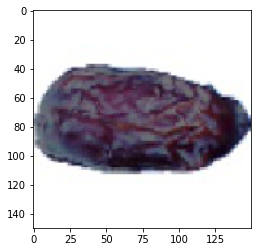

Time for preprocessing and model prediction - 380.8152675628662 ms
Dates Proability - 100.0
Physalis with Husk Proability - 3.454349306597493e-08
Huckleberry Proability - 4.707810877246921e-09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [27]:
#import microsoftvision
from torchvision import transforms
import torch
from PIL import Image
import numpy as np
from google.colab import files
from keras.preprocessing import image
import cv2


transform1 = transforms.Compose([
                                 transforms.Resize(224),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean = [0.406, 0.456, 0.485], std=[0.229, 0.224, 0.225]),
])
uploaded=files.upload()
for fn in uploaded.keys():

  path='/content/' + fn
  #train_dataset = datasets.ImageFolder(path, transform=Preprocess())
   
  # :numpy.ndarray 

  start = time.time()
  img = cv2.imread(path)
  imge=image.load_img(path, target_size=(150, 150),)
  plt.imshow(imge)
  plt.show()
  # normalization, converted to numpy.ndarray and displayed
  img1 = transform1(Image.fromarray(img)) 
  input = img1.unsqueeze(0).cuda()
  input_feat = get_feat(input, model_mv)

  image_data = Tensor(input_feat)
  image_data = image_data.cuda()
  since = time.time()
  outputs = model_ft(image_data)
  sm = torch.nn.Softmax()
  probabilities = sm(outputs) 
  class_index = torch.topk(probabilities,3).indices.squeeze().tolist()
  class_proab = torch.topk(probabilities,3).values.squeeze().tolist()
  #print(f'Time for Model prediction - {(time.time()-since)*1000} ms')
  print(f'Time for preprocessing and model prediction - {(time.time()-start)*1000} ms')
  print("{} Proability - {}".format(classes[class_index[0]], class_proab[0]*100))
  print("{} Proability - {}".format(classes[class_index[1]], class_proab[1]*100)) 
  print("{} Proability - {}".format(classes[class_index[2]], class_proab[2]*100))  

# **11. Conclusion**

Training Accuracy after 10 Epochs - 99%<br>
Validation Accuracy  - 99%<br>
Testing Accuracy - 98%

# **12 References**

* [Microsoft Vision](https://pypi.org/project/microsoftvision/)
* Data Fruit 360 - Oltean, Mihai (2018),<br> 
“Fruits 360 dataset”, <br>
Mendeley Data, V1, doi: 10.17632/rp73yg93n8.1
* https://pypi.org/project/microsoftvision/